#### Задание.
Примените технологию residual connection для нейросети из лаборатороной работы № 1. Сделайте отображение величины ошибки для тренировочной и валидационной выборки нак графике в процесе вычислений. Отобразите результат классификации с указанием класса-результата и верного ответа для 10 случайныз картинок тестовой выборки.

In [1]:
import torch
from torchvision import datasets

In [2]:
download_dir = "./dataset"

# Скачиваем обучающую выборку.
train_data = datasets.CIFAR10(root=download_dir, download=True, train=True)

# Скачиваем валидационную выборку.
val_data = datasets.CIFAR10(root=download_dir, download=True, train=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 34963048.89it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [6]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [3]:
x_train = torch.tensor(train_data.data) / 255.0
y_train = torch.tensor(train_data.targets)

x_val = torch.tensor(val_data.data) / 255.0
y_val = torch.tensor(val_data.targets)

In [7]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки.
classes_ru = [
    "самолёт",
    "машина",
    "птица",
    "кошка",
    "олень",
    "собака",
    "лягушка",
    "лошадь",
    "корабль",
    "грузовик",
]

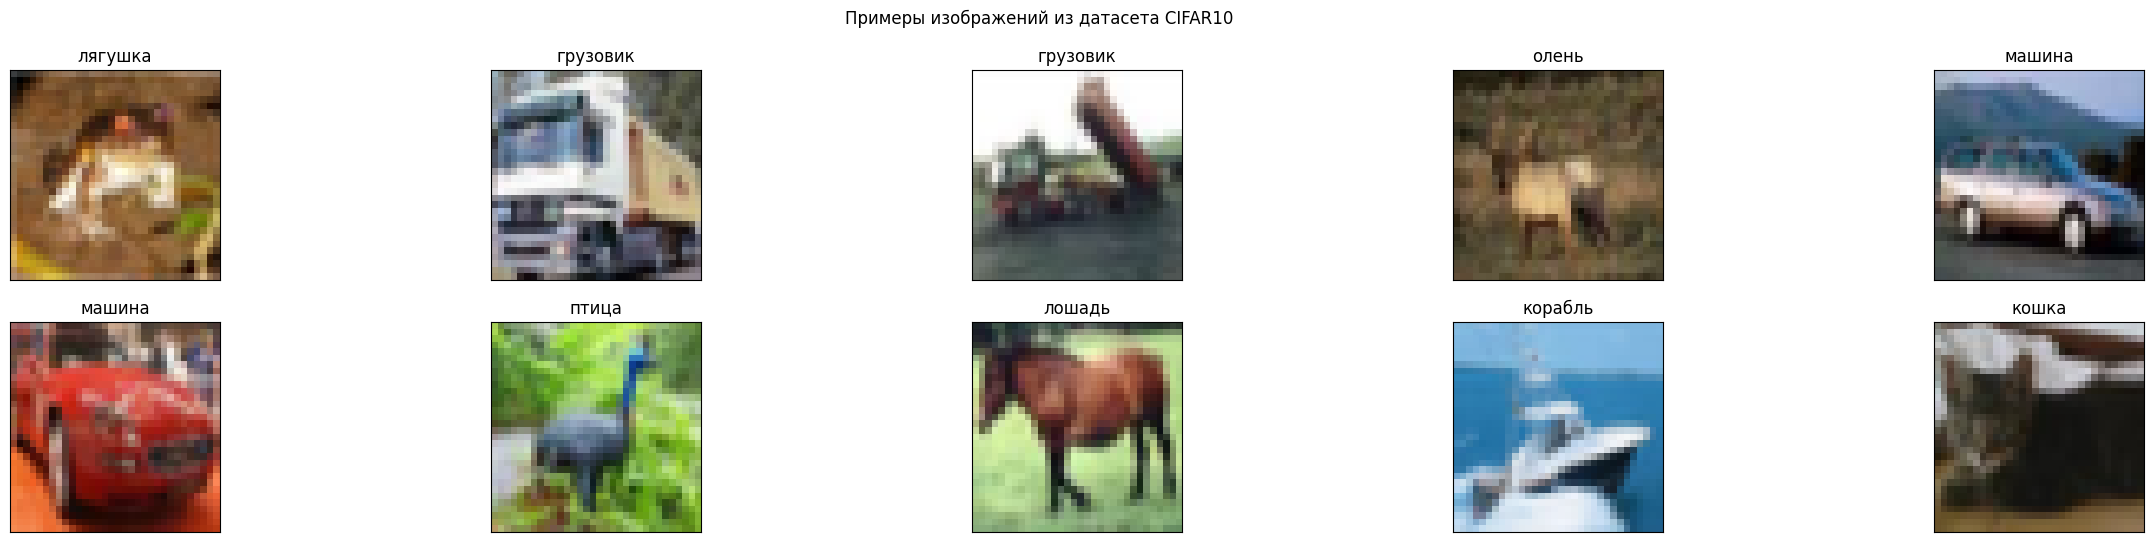

In [12]:
# Посмотрим на то, как выглядят картинки из датасета.
import matplotlib.pyplot as plt
%matplotlib inline

hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 3 * hh))
fig.suptitle("Примеры изображений из датасета CIFAR10")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes_ru[y])
plt.show()

In [13]:
from collections import OrderedDict
from IPython.display import clear_output

class ResidualBlock(torch.nn.Module):
    def __init__(
        self,
        input_c,
        output_c,
        kernel_size,
        activation=torch.nn.ReLU,
    ):
        super().__init__()
        self.activation = activation()
        padding_size = kernel_size // 2
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,
            out_channels=output_c,
            kernel_size=kernel_size,
            padding=padding_size,
            padding_mode="zeros",
            stride=1,
            dilation=1,
        )
        if input_c != output_c:
            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,
                out_channels=output_c,
                kernel_size=1,
            )
        else:
            self.correct_channels = torch.nn.Identity()

    def forward(self, x):
        return self.activation(self.conv(x) + self.correct_channels(x))

In [31]:
class LeNet5_Residual(torch.nn.Module):
    def __init__(self):
        super(LeNet5_Residual, self).__init__()
        self.residual_block1 = ResidualBlock(3, 32, 5)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.residual_block2 = ResidualBlock(32, 64, 5)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(64 * 8 * 8, 400)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(400, 100)
        self.fc3 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.residual_block1(x)
        x = self.maxpool1(x)
        x = self.residual_block2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [17]:
# Меняем порядок размерности в тензоре
x_train = x_train.permute(0, 3, 1, 2)
x_val = x_val.permute(0, 3, 1, 2)

In [32]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5000
batch_size = 1000
val_every = 5

model = LeNet5_Residual().to(dtype=x_train.dtype, device=device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.CrossEntropyLoss()

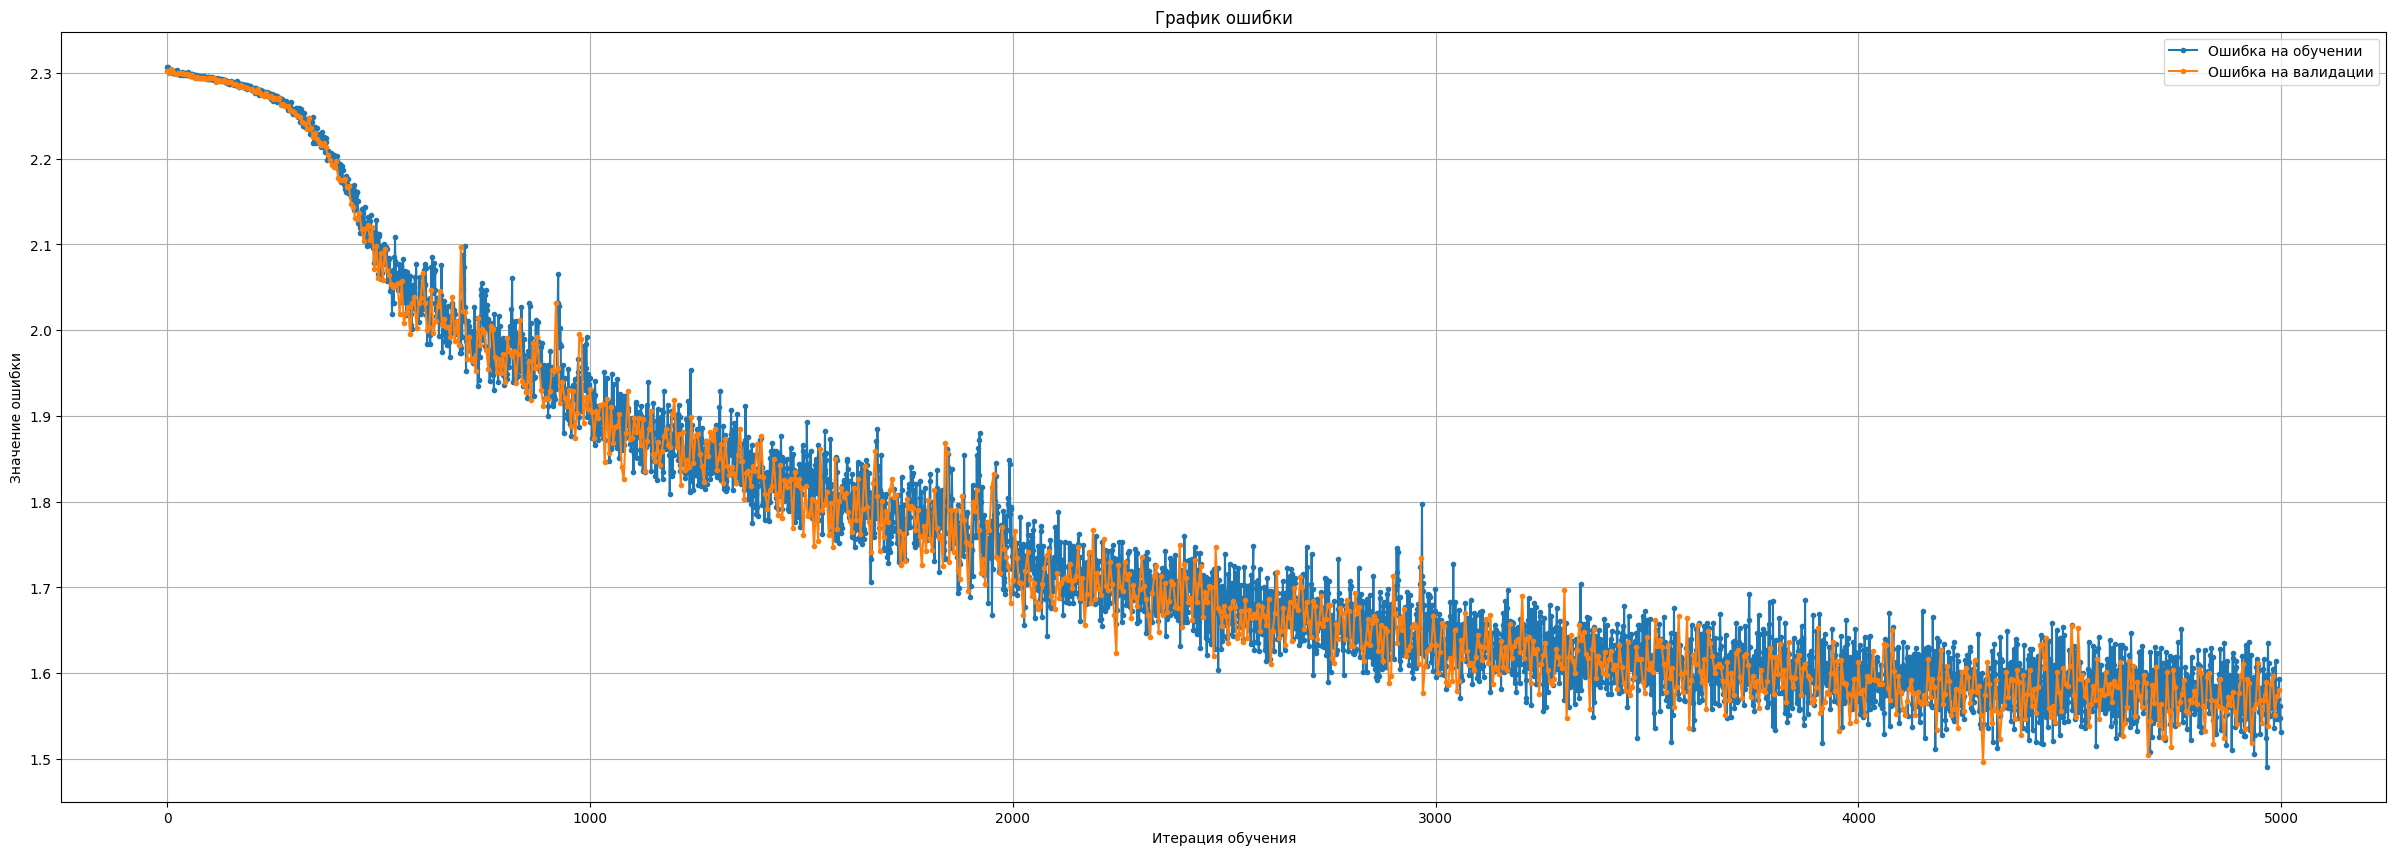

In [33]:
losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])

    pred = model(x_train[batch_pos].to(device))
    loss = loss_fn(pred, y_train[batch_pos].to(device))

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())

    if epoch % 1000 == 0:
        scheduler.step()

    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

In [34]:
def show_results(model, h=2, w=5):
    with torch.no_grad():
        batch_probs = model(x_val[:h*w].to(device)).softmax(dim=1)

        fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            image_to_display = x_val[i].permute(1, 2, 0)
            plt.imshow(image_to_display)
            title = f'Реальный класс: {classes_ru[y_val[i]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[i] else "+ ",
                    classes_ru[j],
                    round(prob.item(), 4),
                )

            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

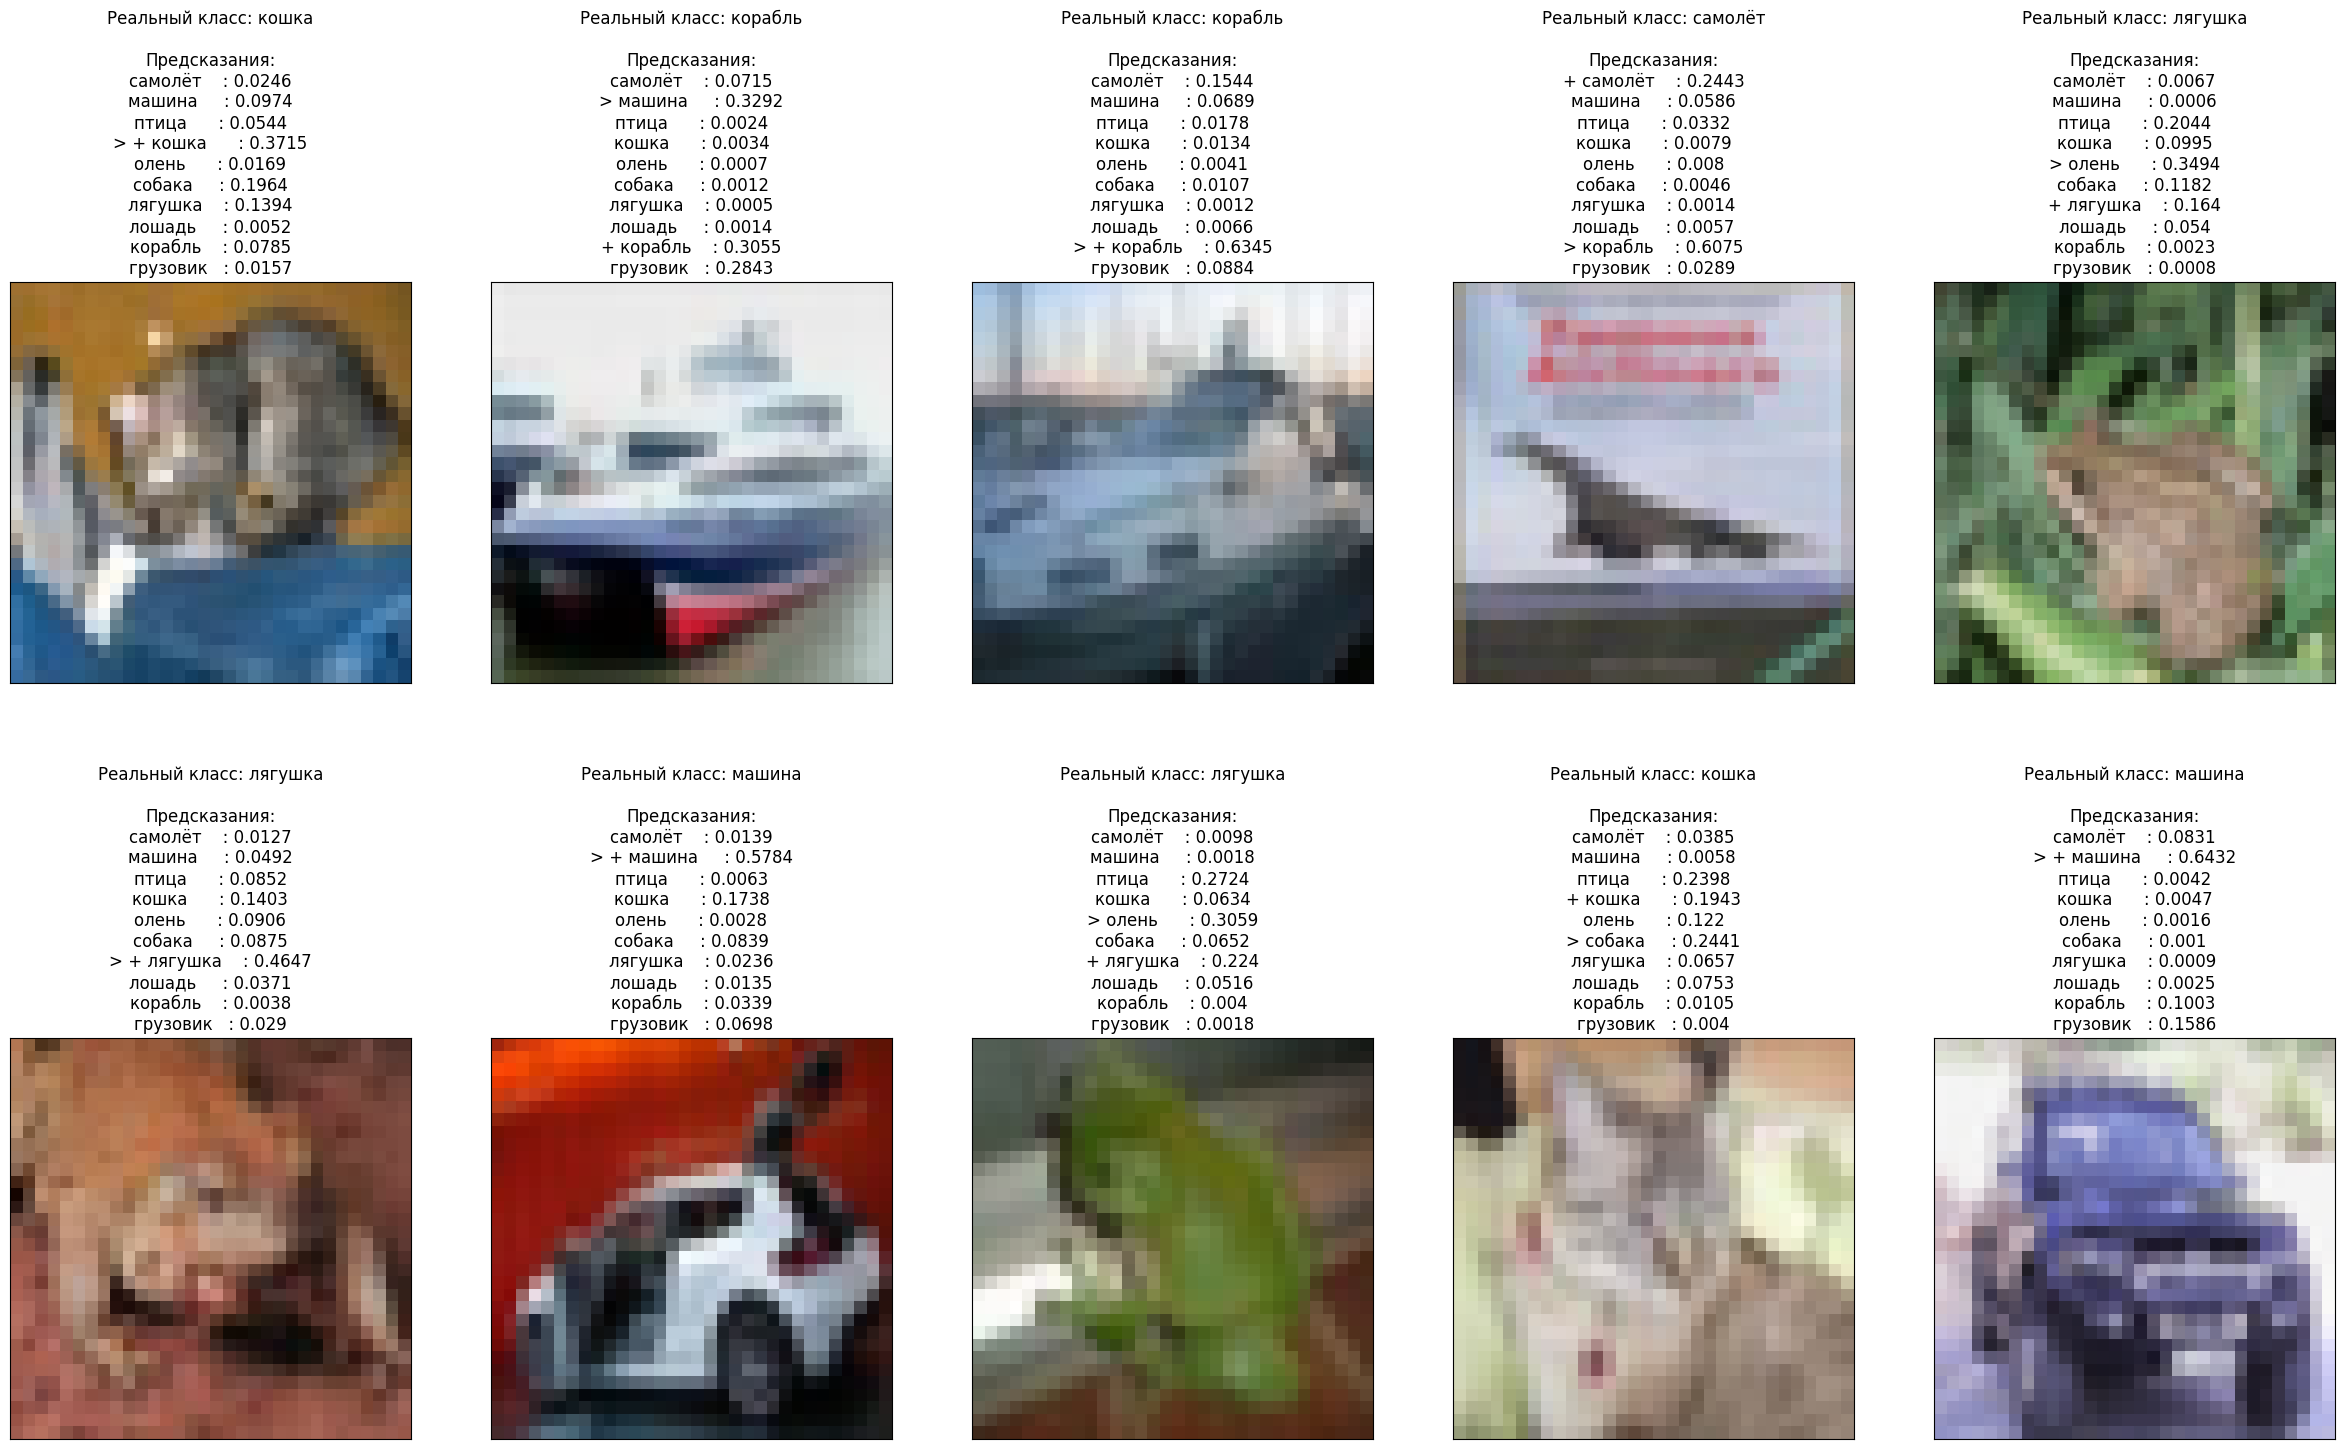

In [35]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки.
show_results(model)

In [36]:
def show_results1(model, image_indices, h=2, w=5):
    with torch.no_grad():
        # Используем image_indices для выбора изображений
        selected_images = x_val[image_indices].to(device)
        batch_probs = model(selected_images).softmax(dim=1)

        fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
        for i, image_index in enumerate(image_indices):
            plt.subplot(h, w, i + 1)
            image_to_display = x_val[image_index].permute(1, 2, 0)
            plt.imshow(image_to_display)
            title = f'Реальный класс: {classes_ru[y_val[image_index]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[image_index] else "+ ",
                    classes_ru[j],
                    round(prob.item(), 4),
                )

            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

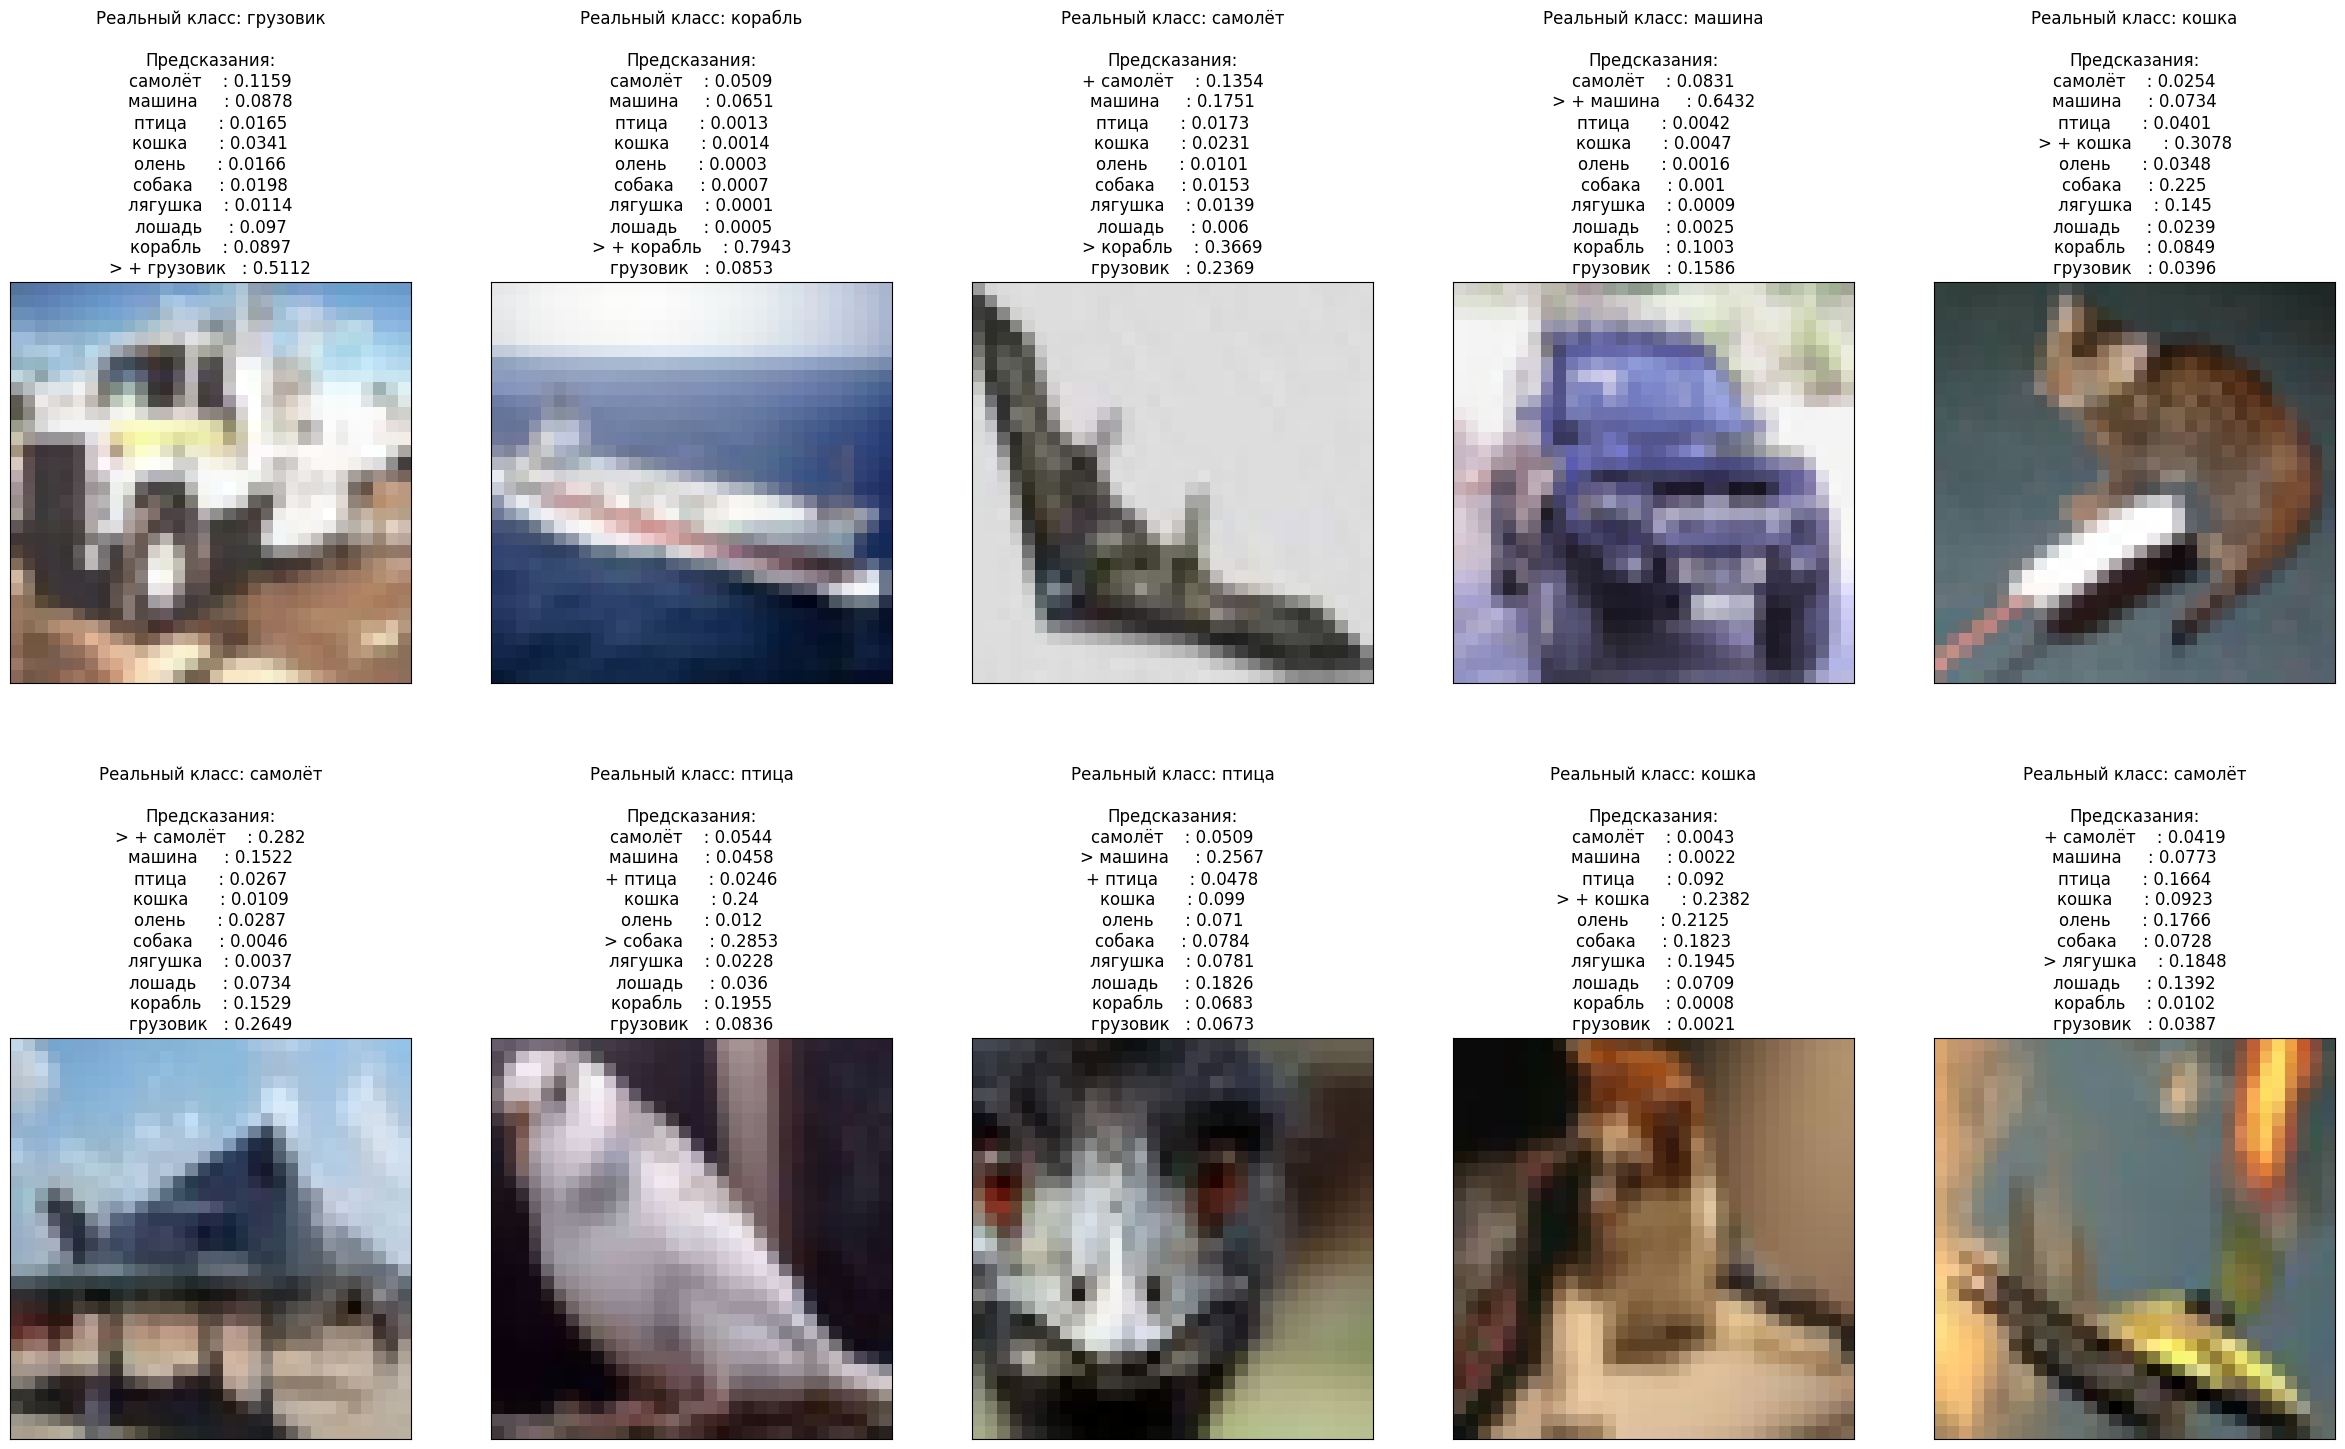

In [42]:
# Посмотрим на предсказания нашей модели на рандомных примерах из валидационной выборки.
import random

image_indices_to_display = random.sample(range(0, 200 + 1), 10)
show_results1(model, image_indices_to_display, h=2, w=5)